# Part A


- **Discrete Latent Space:** VQ-VAE is argued to effectively model important features that span many dimensions in data space, such as objects in images or phonemes in speech. The discrete latent space allows the model to focus on essential information rather than noise and imperceptible details.Discrete representations are potentially a more natural fit for many of the modalities we are interested in. Language is inherently discrete, similarly speech is typically represented as a sequence of symbols. Images can often be described concisely by language. Furthermore, discrete representations are a natural fit for complex reasoning.





- **Posterior Collapse:** The VQ-VAE model is designed to avoid the "posterior collapse" issue, where latent variables are ignored, often caused by powerful decoders in VAE models.

# Part B

In [1]:
# Import libraries
import os
import cv2
import glob
import torch
import shutil
import random
import argparse
import torchvision

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from einops import einsum
from einops import rearrange
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataloader import DataLoader

In [2]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset_temp = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset_temp = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [3]:
# Create MnistDataset from loaded dataset and implement number of channels (1 or 3)
class MnistDataset(Dataset):
    def __init__(self, split, im_channels):
        self.split = split
        self.im_channels = im_channels
        self.images, self.labels = self.load_images(split)

    def load_images(self,split):
        ims = []
        labels = []
        for idx in range(split.__len__()):
            img, label = split.__getitem__(idx)
            ims.append(np.array(img).reshape(28,28))
            labels.append(label)

        return ims, labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        if self.im_channels == 1:
            im = self.images[index]
        else:
            # Generate a random color digit
            im_1 = self.images[index][None, :]*np.clip(random.random(), 0.2, 1.0)
            im_2 = self.images[index][None, :]*np.clip(random.random(), 0.2, 1.0)
            im_3 = self.images[index][None, :]*np.clip(random.random(), 0.2, 1.0)
            im = np.concatenate([im_1, im_2, im_3], axis=0)

        label = self.labels[index]
#         im = 2*im -1
        im_tensor = torch.from_numpy(im)[None, :] if self.im_channels == 1 else torch.from_numpy(im)
        return im_tensor, torch.as_tensor(label)

In [4]:
# Create mnist dataset object set im_channels=1
mnist = MnistDataset(split=train_dataset_temp, im_channels=1)

# Create dataloader with batch_size = 128 
mnist_loader = DataLoader(mnist, batch_size=128, shuffle=True, num_workers=0)
for im, label in mnist_loader:
    print('Image dimension:', im.shape)
    print('Label dimension: {}'.format(label.shape))
    break

Image dimension: torch.Size([128, 1, 28, 28])
Label dimension: torch.Size([128])


# Part C, D, & E

In [5]:
# Implement VQVAE claa
class VQVAE(nn.Module):
    def __init__(self):
        super(VQVAE, self).__init__()
        
        # Encoder architecture
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),)
        
        self.pre_quant_conv = nn.Conv2d(4, 2, kernel_size=1)
        self.embedding = nn.Embedding(num_embeddings=3, embedding_dim=2)
        self.post_quant_conv = nn.Conv2d(2, 4, kernel_size=1)
        
        # Commitment Loss Beta
        self.beta = 0.2
        
        # Decoder architecture
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
            nn.Sigmoid(),)
        
    # forward path
    def forward(self, x):
        # B, C, H, W
        encoded_output = self.encoder(x)
        quant_input = self.pre_quant_conv(encoded_output)
        
        # Quantization
        B, C, H, W = quant_input.shape
        quant_input = quant_input.permute(0, 2, 3, 1)
        quant_input = quant_input.reshape((quant_input.size(0), -1, quant_input.size(-1)))
        
        # Compute pairwise distances
        dist = torch.cdist(quant_input, self.embedding.weight[None, :].repeat((quant_input.size(0), 1, 1)))
        
        # Find index of nearest embedding
        min_encoding_indices = torch.argmin(dist, dim=-1)
        
        # Select the embedding weights
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        quant_input = quant_input.reshape((-1, quant_input.size(-1)))
        
        # Save embedding weights(code book vectors)
        codebookvecs = self.embedding.weight
        
        # Compute losses
        commitment_loss = torch.mean((quant_out.detach() - quant_input)**2)
        codebook_loss = torch.mean((quant_out - quant_input.detach())**2)
        quantize_losses = codebook_loss + self.beta*commitment_loss
        
        # Ensure straight through gradient
        quant_out = quant_input + (quant_out - quant_input).detach()
        
        # Reshaping back to original input shape
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        
        
        ## Decoder part
        decoder_input = self.post_quant_conv(quant_out)
        output = self.decoder(decoder_input)
        return output, quantize_losses, quant_out, codebookvecs

# Part F

In [6]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create model
model = VQVAE().to(device)

# Set train parameters
num_epochs = 25
optimizer = Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# For store total loss in each iteration
totalLossPlot = []

# for gif and plot (G and H)
iternum = 0

input_images_for_show = []
output_images_for_show = []
quantized_iamges_for_show = []
codebookvecs_for_show = []


# Train loop
for epoch_idx in range(num_epochs):
    model.train()
    totloss_per_epoch = []
    recons_losses = []
    quant_loss = []
    
    # loop through batchs
    for im, label in tqdm(mnist_loader):
        
        im = im.float().to(device)
        optimizer.zero_grad()
        out, quantize_loss, quant_output, codebookvecs = model(im)

        recon_loss = criterion(out, im)
        loss = recon_loss + quantize_loss
        loss.backward()
        optimizer.step()
        totalLossPlot.append(loss.item())
        totloss_per_epoch.append(loss.item())
        recons_losses.append(recon_loss.item())
        quant_loss.append(quantize_loss.item())
        
        # save for show
        if (iternum%20) == 0 :
            # Save to lists for show
            input_images_for_show.append(im.detach()[0])
            
            output_images_for_show.append(out.detach()[0])
            
            quantized_iamges_for_show.append(quant_output.detach()[0])
            
            codebookvecs_for_show.append(codebookvecs.detach())
            
        iternum +=1
        
    print('Finished epoch:{} || Tatal Loss:{:.4f} || Reconstruction Loss:{:.4f} || Quantization Loss:{:.4f}'.format(epoch_idx+1, np.mean(totloss_per_epoch), np.mean(recons_losses), np.mean(quant_loss)))

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.57it/s]


Finished epoch:1 || Tatal Loss:0.1384 || Reconstruction Loss:0.1283 || Quantization Loss:0.0101


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.77it/s]


Finished epoch:2 || Tatal Loss:0.0967 || Reconstruction Loss:0.0966 || Quantization Loss:0.0001


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.77it/s]


Finished epoch:3 || Tatal Loss:0.0908 || Reconstruction Loss:0.0908 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.87it/s]


Finished epoch:4 || Tatal Loss:0.0881 || Reconstruction Loss:0.0881 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.71it/s]


Finished epoch:5 || Tatal Loss:0.0866 || Reconstruction Loss:0.0866 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.85it/s]


Finished epoch:6 || Tatal Loss:0.0859 || Reconstruction Loss:0.0858 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.86it/s]


Finished epoch:7 || Tatal Loss:0.0854 || Reconstruction Loss:0.0854 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.65it/s]


Finished epoch:8 || Tatal Loss:0.0851 || Reconstruction Loss:0.0851 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.88it/s]


Finished epoch:9 || Tatal Loss:0.0849 || Reconstruction Loss:0.0849 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.87it/s]


Finished epoch:10 || Tatal Loss:0.0848 || Reconstruction Loss:0.0848 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.69it/s]


Finished epoch:11 || Tatal Loss:0.0847 || Reconstruction Loss:0.0847 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.61it/s]


Finished epoch:12 || Tatal Loss:0.0846 || Reconstruction Loss:0.0846 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.82it/s]


Finished epoch:13 || Tatal Loss:0.0846 || Reconstruction Loss:0.0846 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.74it/s]


Finished epoch:14 || Tatal Loss:0.0846 || Reconstruction Loss:0.0846 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.88it/s]


Finished epoch:15 || Tatal Loss:0.0845 || Reconstruction Loss:0.0845 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.79it/s]


Finished epoch:16 || Tatal Loss:0.0845 || Reconstruction Loss:0.0845 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.81it/s]


Finished epoch:17 || Tatal Loss:0.0845 || Reconstruction Loss:0.0845 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.76it/s]


Finished epoch:18 || Tatal Loss:0.0845 || Reconstruction Loss:0.0845 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.62it/s]


Finished epoch:19 || Tatal Loss:0.0845 || Reconstruction Loss:0.0845 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:28<00:00, 16.48it/s]


Finished epoch:20 || Tatal Loss:0.0845 || Reconstruction Loss:0.0845 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.78it/s]


Finished epoch:21 || Tatal Loss:0.0845 || Reconstruction Loss:0.0845 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:27<00:00, 16.81it/s]


Finished epoch:22 || Tatal Loss:0.0845 || Reconstruction Loss:0.0845 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:23<00:00, 19.77it/s]


Finished epoch:23 || Tatal Loss:0.0845 || Reconstruction Loss:0.0845 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 34.90it/s]


Finished epoch:24 || Tatal Loss:0.0845 || Reconstruction Loss:0.0845 || Quantization Loss:0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 36.72it/s]

Finished epoch:25 || Tatal Loss:0.0845 || Reconstruction Loss:0.0845 || Quantization Loss:0.0000


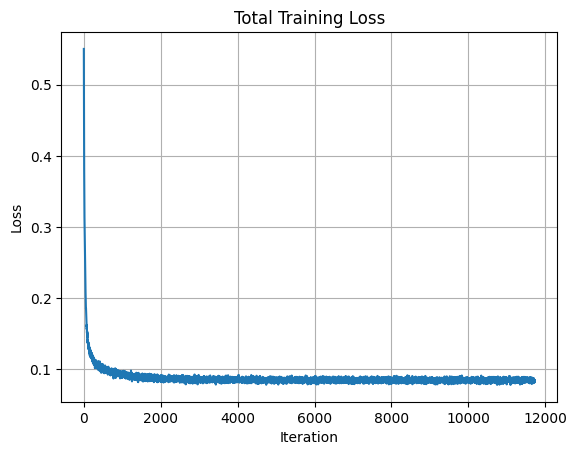

In [7]:
# plot loss
plt.plot(np.arange(1,num_epochs*469+1), totalLossPlot)
plt.title('Total Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid()
plt.show()

# Part G

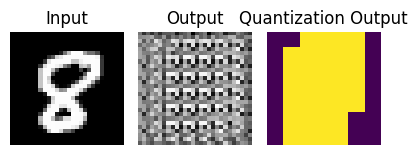

<Figure size 640x480 with 0 Axes>

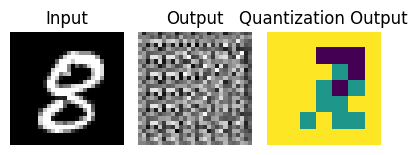

<Figure size 640x480 with 0 Axes>

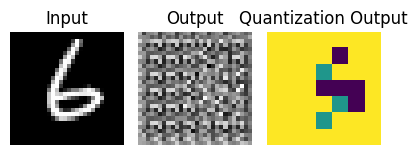

<Figure size 640x480 with 0 Axes>

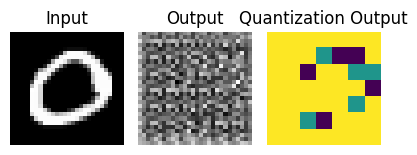

<Figure size 640x480 with 0 Axes>

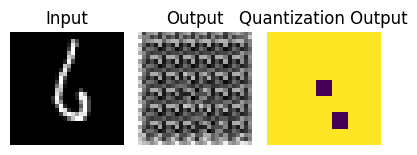

<Figure size 640x480 with 0 Axes>

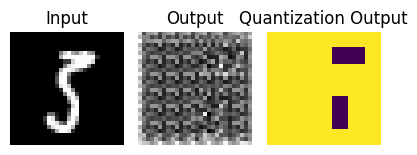

<Figure size 640x480 with 0 Axes>

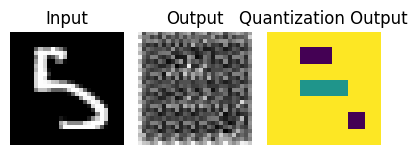

<Figure size 640x480 with 0 Axes>

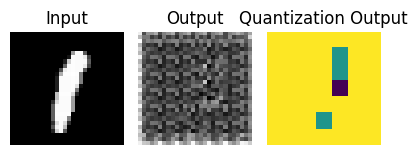

<Figure size 640x480 with 0 Axes>

In [8]:
# Plot Input, Output, Quantization Output for some datapoints

# Define the plot titles
image_names = ['Input', 'Output', 'Quantization Output']

for i in range(8):
    
    fig, axes = plt.subplots(1, 3, figsize=(4, 2))

    # Plot input image
    axes[0].imshow(np.array(input_images_for_show[i]).reshape(28,28), cmap='gray')
    axes[0].set_title(image_names[0])
    axes[0].set_axis_off()

    # Plot output image
    axes[1].imshow(np.array(output_images_for_show[i]).reshape(28,28), cmap='gray')
    axes[1].set_title(image_names[1])
    axes[1].set_axis_off()

    # Plot Codebook Output, Sum of channels
    axes[2].imshow((np.array(quantized_iamges_for_show[i][0]) + np.array(quantized_iamges_for_show[i][1]) ).reshape(7,7))
    axes[2].set_title(image_names[2])
    axes[2].set_axis_off()

    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    plt.figure()

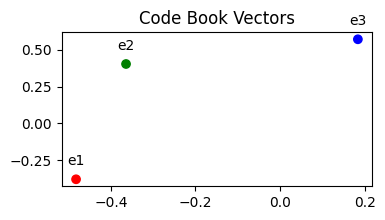

In [9]:
# Plot Codebooks
fig, ax = plt.subplots(figsize=(4, 2))
e_s = np.array(codebookvecs_for_show[0])
x = e_s[:,0]
y = e_s[:,1]

# set label and color for each vector
labels = ['e1', 'e2', 'e3']
colors = ['red', 'green', 'blue']

# Scatter plot
scatter = ax.scatter(x, y, c=colors, label=labels)

# Annotate each point with its label
for i, label in enumerate(labels):
    ax.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

# Set plot title and labels
ax.set_title('Code Book Vectors')

plt.show()

# Part H

In [10]:
# A function for get codebooke vectors and save them as an image
def create_image_coodbookvecs(vecs, indexname):
    # Get codebook vectors
    e_s = np.array(vecs.detach())
    x = e_s[:,0]
    y = e_s[:,1]

    # set label and color for each vector
    labels = ['e1', 'e2', 'e3']
    colors = ['red', 'green', 'blue']

    # Create a figure
    fig, ax = plt.subplots(figsize=(8, 4))

    # Scatter plot
    scatter = ax.scatter(x, y, c=colors, label=labels)

    # Annotate each point with its label
    for i, label in enumerate(labels):
        ax.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(0,10), ha='center')

    # Set plot title and labels
    ax.set_title(f'Code Book Vectors Iteration:{indexname+1}')

    # Save the plot
    fig.savefig(f'codebookvectors/codebookvecs_iter_{indexname+1}.png')

    # Close the figure
    plt.close(fig)

In [11]:
# Apply the function on the codebook list to create the frames
for i in tqdm(range(len(codebookvecs_for_show))):
    create_image_coodbookvecs(codebookvecs_for_show[i],i)

100%|████████████████████████████████████████████████████████████████████████████████| 587/587 [00:58<00:00,  9.99it/s]


In [12]:
# Make a video from stored plots
image_folder = 'codebookvectors'

# Output video file name
video_name = 'codebook_vectors_video.avi'

# Frame rate
fps = 30

# Get H and W
frame = cv2.imread(f'codebookvectors/codebookvecs_iter_{1}.png')
height, width, _ = frame.shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(video_name, fourcc, fps, (width, height))

# Loop through images and write it to the video
for i in range(len(input_images_for_show)):
    frame = cv2.imread(f'codebookvectors/codebookvecs_iter_{i+1}.png')
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    video.write(frame)

# Release the VideoWriter
video.release()
cv2.destroyAllWindows()
print('Done!')

Done!


In [13]:
# create plots and save them  as frames for  Input/Output/Quantization video
image_names = ['Input', 'Output', 'Quantization Output']

for i in tqdm(range(len(input_images_for_show))):
    
    fig, axes = plt.subplots(1, 3, figsize=(8, 4))

    # Plot input image
    axes[0].imshow(np.array(input_images_for_show[i]).reshape(28,28), cmap='gray')
    axes[0].set_title(image_names[0])
    axes[0].set_axis_off()

    # Plot output image
    axes[1].imshow(np.array(output_images_for_show[i]).reshape(28,28), cmap='gray')
    axes[1].set_title(image_names[1])
    axes[1].set_axis_off()

    # Plot Codebook Output, Sum of channels
    axes[2].imshow((np.array(quantized_iamges_for_show[i][0]) + np.array(quantized_iamges_for_show[i][1])).reshape(7,7))
    axes[2].set_title(image_names[2])
    axes[2].set_axis_off()
    
    # Set a title for the entireplot
    fig.suptitle(f'Iteration:{i+1}', fontsize=16)

    # Adjust layout
    plt.tight_layout()
    
    # Save the plot
    fig.savefig(f'IOQ/IOQ_iter_{i+1}.png')

    # Close the figure
    plt.close(fig)

100%|████████████████████████████████████████████████████████████████████████████████| 587/587 [01:14<00:00,  7.84it/s]


In [14]:
# Make a video from stored plots
image_folder = 'IOQ'

# Output video file name
video_name = 'IOQ_video.avi'

# Frame rate
fps = 10

# Get H and W
frame = cv2.imread(f'IOQ/IOQ_iter_{1}.png')
height, width, _ = frame.shape


# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(video_name, fourcc, fps, (width, height))

# Loop through each image and write it to the video
for i in tqdm(range(len(input_images_for_show))):
    frame = cv2.imread(f'IOQ/IOQ_iter_{i+1}.png')
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    video.write(frame)

# Release the VideoWriter
video.release()
cv2.destroyAllWindows()
print('Done!')

100%|███████████████████████████████████████████████████████████████████████████████| 587/587 [00:04<00:00, 131.71it/s]

Done!


# Part I (RGB MNIST)

## a

In [15]:
# Create  Colored MNIST (RGB) dataset object, set im_channels = 3
mnist_rgb = MnistDataset(split=train_dataset_temp, im_channels=3)

# Create dataloader with batch_size = 128
mnist_loader_rgb = DataLoader(mnist_rgb, batch_size=128, shuffle=True, num_workers=0)
for im, label in mnist_loader_rgb:
    print('Image dimension:', im.shape)
    print('Label dimension: {}'.format(label.shape))
    break

Image dimension: torch.Size([128, 3, 28, 28])
Label dimension: torch.Size([128])


In [16]:
# A function for plot MNIST RGB images
def rgb_to_plot(tensor_rgb):
    temp = np.zeros((28,28,3))
    temp[:,:,0] = tensor_rgb[0,:,:]
    temp[:,:,1] = tensor_rgb[1,:,:]
    temp[:,:,2] = tensor_rgb[2,:,:]
    return temp

## b

In [17]:
# Create a VQVAERGB class for 3-channel images
class VQVAERGB(nn.Module):
    def __init__(self, numvectors, dimvectors):
        super(VQVAERGB, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 4, 4, stride=2, padding=1),
            nn.BatchNorm2d(4),
            nn.ReLU(),)
        
        self.pre_quant_conv = nn.Conv2d(4, dimvectors, kernel_size=1)
        self.embedding = nn.Embedding(num_embeddings=numvectors, embedding_dim=dimvectors)
        self.post_quant_conv = nn.Conv2d(dimvectors, 4, kernel_size=1)
        
        # Commitment Loss Beta
        self.beta = 0.2
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),)
        
        
    def forward(self, x):
        # B, C, H, W
        encoded_output = self.encoder(x)
        quant_input = self.pre_quant_conv(encoded_output)
        
        # Quantization
        B, C, H, W = quant_input.shape
        quant_input = quant_input.permute(0, 2, 3, 1)
        quant_input = quant_input.reshape((quant_input.size(0), -1, quant_input.size(-1)))
        
        # Compute pairwise distances
        dist = torch.cdist(quant_input, self.embedding.weight[None, :].repeat((quant_input.size(0), 1, 1)))
        
        # Find index of nearest embedding
        min_encoding_indices = torch.argmin(dist, dim=-1)
        
        # Select the embedding weights
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))
        quant_input = quant_input.reshape((-1, quant_input.size(-1)))
        
        # Compute losses
        commitment_loss = torch.mean((quant_out.detach() - quant_input)**2)
        codebook_loss = torch.mean((quant_out - quant_input.detach())**2)
        quantize_losses = codebook_loss + self.beta*commitment_loss
        
        # Ensure straight through gradient
        quant_out = quant_input + (quant_out - quant_input).detach()
        
        # Reshaping back to original input shape
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        
        
        # Decoder part
        decoder_input = self.post_quant_conv(quant_out)
        output = self.decoder(decoder_input)
        return output, quantize_losses

In [126]:
def train_rgb(model_rgb , num_epochs):
    
    # Set training parameters
    optimizer = Adam(model_rgb.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    # Training loop
    for epoch_idx in range(num_epochs):
        model_rgb.train()
        totloss_per_epoch = []
        recuns_loss = []
        quant_loss = []

        # Loop through the batches
        for im, label in tqdm(mnist_loader_rgb):
            im = im.float().to(device)
            optimizer.zero_grad()
            out, quantize_loss = model_rgb(im)

            recon_loss = criterion(out, im)
            loss = recon_loss + quantize_loss
            loss.backward()
            optimizer.step()
            totloss_per_epoch.append(loss.item())
            recuns_loss.append(recon_loss.item())
            quant_loss.append(quantize_loss.item())
        print('Finished epoch:{} || Tatal Loss:{:.4f} || Reconst Loss:{:.4f} || Quant Loss:{:.4f}'.format(epoch_idx+1, np.mean(totloss_per_epoch), np.mean(recuns_loss), np.mean(quant_loss)))
    
    
    # get a output batch for plot the images
    model_rgb.eval()
    
    # Loop through the batches
    for im, label in mnist_loader_rgb:
        im = im.float().to(device)
        final_output, _ = model_rgb(im)
      
    print('**************************************************************************************************')
    
    return final_output
    
    

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.25it/s]


Finished epoch:1 || Tatal Loss:0.13770359368530163 || Reconst Loss:0.10579741393515804 || Quant Loss:0.03190617963496937


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.21it/s]


Finished epoch:2 || Tatal Loss:0.07563558382901556 || Reconst Loss:0.04575909450173632 || Quant Loss:0.029876489212105013


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.24it/s]


Finished epoch:3 || Tatal Loss:0.07893549793882411 || Reconst Loss:0.0415799888307606 || Quant Loss:0.03735550890551574


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.25it/s]


Finished epoch:4 || Tatal Loss:0.08103523452653051 || Reconst Loss:0.037820433407450026 || Quant Loss:0.043214801071422185


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.22it/s]


Finished epoch:5 || Tatal Loss:0.07751421709813035 || Reconst Loss:0.034679716357639605 || Quant Loss:0.04283450070474702


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.19it/s]


Finished epoch:6 || Tatal Loss:0.07745666037808095 || Reconst Loss:0.03293211179882733 || Quant Loss:0.044524548309189935


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.20it/s]


Finished epoch:7 || Tatal Loss:0.07961557587898617 || Reconst Loss:0.03178788707263942 || Quant Loss:0.04782768869514405


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.24it/s]


Finished epoch:8 || Tatal Loss:0.0828376523276636 || Reconst Loss:0.0307623117661743 || Quant Loss:0.052075340454258136


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:42<00:00, 11.16it/s]


Finished epoch:9 || Tatal Loss:0.08627056127100356 || Reconst Loss:0.03006440401474423 || Quant Loss:0.05620615733966136


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.22it/s]


Finished epoch:10 || Tatal Loss:0.08781984186312283 || Reconst Loss:0.02923225365213748 || Quant Loss:0.0585875883460172


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.19it/s]


Finished epoch:11 || Tatal Loss:0.08711984772672023 || Reconst Loss:0.028517526465215916 || Quant Loss:0.05860232130519109


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.21it/s]


Finished epoch:12 || Tatal Loss:0.08523881718166855 || Reconst Loss:0.027688963434049314 || Quant Loss:0.05754985365627417


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.20it/s]


Finished epoch:13 || Tatal Loss:0.08591468567088215 || Reconst Loss:0.027366571434175792 || Quant Loss:0.05854811421684873


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.22it/s]


Finished epoch:14 || Tatal Loss:0.08632500090006827 || Reconst Loss:0.02725777717064947 || Quant Loss:0.05906722377707709


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.19it/s]


Finished epoch:15 || Tatal Loss:0.08447774058021208 || Reconst Loss:0.026760863644609063 || Quant Loss:0.057716876856172515


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.20it/s]


Finished epoch:16 || Tatal Loss:0.08105747511328411 || Reconst Loss:0.026074624403929915 || Quant Loss:0.05498285062595217


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.21it/s]


Finished epoch:17 || Tatal Loss:0.07983972365731623 || Reconst Loss:0.02583167253971608 || Quant Loss:0.054008051149372356


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.24it/s]


Finished epoch:18 || Tatal Loss:0.0795137487304236 || Reconst Loss:0.02551354614020919 || Quant Loss:0.05400020273318931


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.18it/s]


Finished epoch:19 || Tatal Loss:0.07880341911366753 || Reconst Loss:0.02541895081668393 || Quant Loss:0.05338446829301208


100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:41<00:00, 11.19it/s]

Finished epoch:20 || Tatal Loss:0.07804433122944476 || Reconst Loss:0.025357456425073813 || Quant Loss:0.05268687485600077
Done Training...


In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# number of codebook vectros
numvecs = [3, 10, 25, 50]

# Define a dict for save the outputs of models
outputs_numvecs = {}

# Loop through the number of codebook vectors
for num in numvecs:
    
    # Create a model and move to the device
    model_rgb = VQVAERGB(numvectors=num, dimvectors=2).to(device)
    
    # train for 20 epochs
    output_batch = train_rgb(model_rgb = model_rgb , num_epochs = 20 )
    
    # save the outputs for comprasion
    outputs_numvecs[num] = output_batch
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

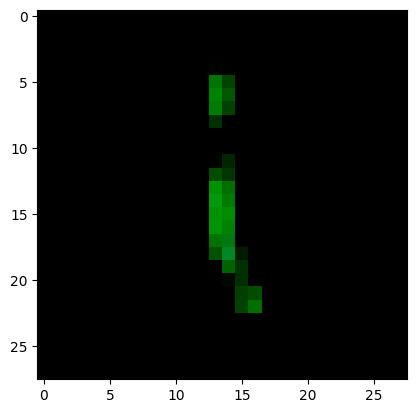

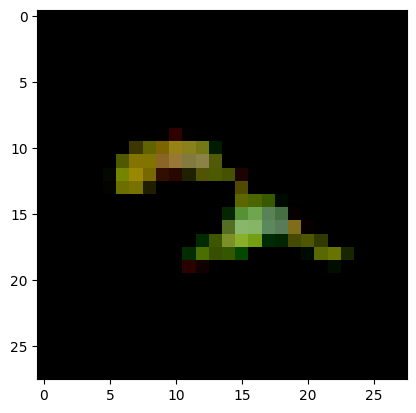

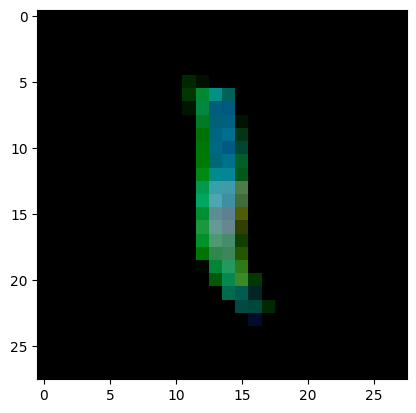

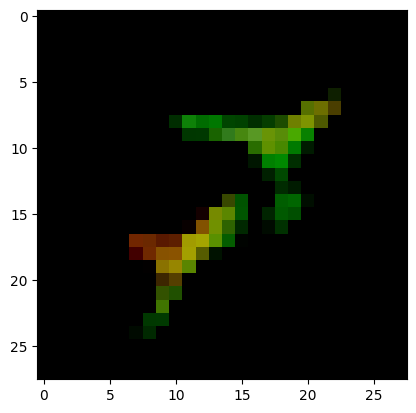

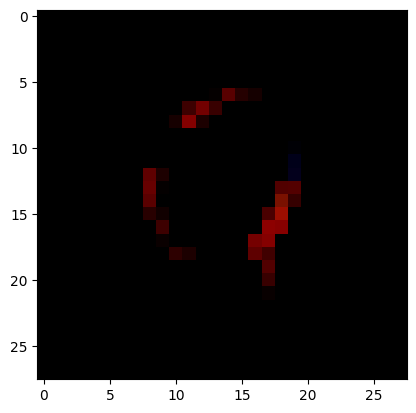

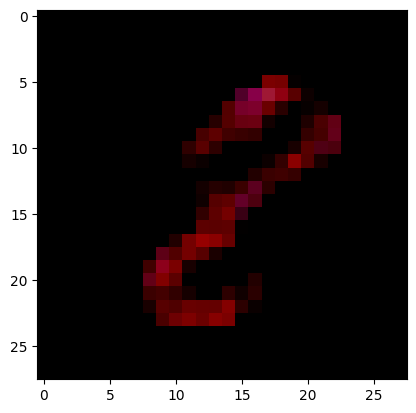

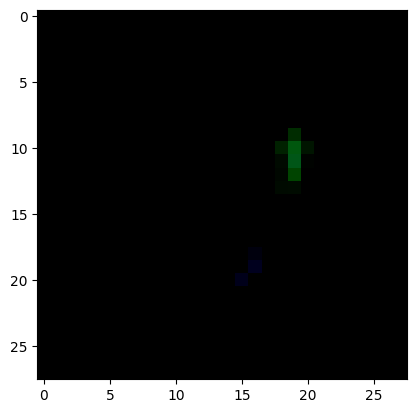

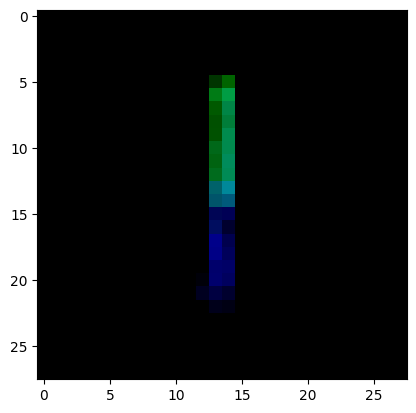

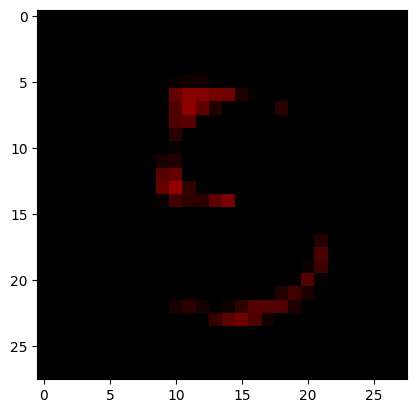

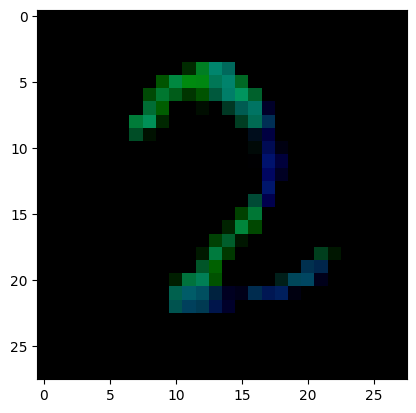

<Figure size 640x480 with 0 Axes>

In [128]:
gens = generated_im.detach()
for i in range(10):
    img_rgb_gen = rgb_to_plot(gens[i])
    plt.imshow(img_rgb_gen)
    plt.figure()

In [ ]:
# A function for plot RGB image as a grid
def plot_rgb_grid(images, title):
    
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(4, 4))

    # Plot each RGB image on the subplots
    axs[0, 0].imshow(image1)
    axs[0, 1].imshow(image2)
    axs[1, 0].imshow(image3)
    axs[1, 1].imshow(image4)

    # Hide the x and y axis labels
    for ax in axs.flat:
        ax.set(xlabel='', ylabel='')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    # Set a title for the entire grid
    fig.suptitle(f'Number of Codebooke Vectors:{title}', fontsize=16)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the plot
    plt.show()
    plt.figure()

## c

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# list of dimansions of codebook vectors
dimansions = [10, 25, 40, 50]

# Define a dict for save the outputs of models
outputs_dims = {}

# Loop through the number of codebook vectors
for dim in dimansions:
    
    # Create a model and move to the device
    model_rgb = VQVAERGB(numvectors=3, dimvectors=dim).to(device)
    
    # train for 20 epochs
    output_batch = train_rgb(model_rgb = model_rgb , num_epochs = 20 )
    
    # save the outputs for comprasion
    outputs_dims[dim] = output_batch
    

In [ ]:
# A function for plot RGB image as a grid
def plot_rgb_grid(images, title):
    
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(4, 4))

    # Plot each RGB image on the subplots
    axs[0, 0].imshow(image1)
    axs[0, 1].imshow(image2)
    axs[1, 0].imshow(image3)
    axs[1, 1].imshow(image4)

    # Hide the x and y axis labels
    for ax in axs.flat:
        ax.set(xlabel='', ylabel='')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    # Set a title for the entire grid
    fig.suptitle(f'Dimansion of Codebooke Vectors:{title}', fontsize=16)

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Show the plot
    plt.show()
    plt.figure()

# **********************************************************************************************